In [1]:
suppressPackageStartupMessages(library(PFAM.db))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(magrittr))

palette_yn = c("Yes" = "#91cf60", "No" = "#d6604d")
palette_driver = c('Driver' = "#b2182b", 
                   'No' = 'gray80', 
                   'Driver interactor' = "#fecc5c")

results <- '../results/'
data <- '../data/'

tumors <- c('ALL', 'AML')

In [2]:
switches <- lapply(tumors, function(t) paste0(results, t, '/switches_final.tsv')) %>%
       lapply(read_tsv, col_types = 'ccccciiiicc') %>%
       bind_rows %>%
       mutate(num_samples = strsplit(Samples, ',') %>% lapply(length) %>% unlist,
              Driver = ifelse(Driver %in% c('Tumor-specific driver', 'Foreign driver'), 'Driver', Driver),
              Driver = factor(Driver, levels = c('Driver', 'Driver interactor', 'No')))

In [3]:
pfam_ids <- as.data.frame(PFAMID) %>%
    set_colnames(c('Feature', 'Description')) %>%
    mutate(Description = gsub('_', ' ', Description))

pfam <- lapply(tumors, function(t) paste0(results, t, '/pfam_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccidddddddddd') %>%
    bind_rows %>%
    left_join(pfam_ids)
               
prosite <- lapply(tumors, function(t) paste0(results, t, '/prosite_analysis.tsv')) %>%
    lapply(read_tsv, col_types = 'cccccccidddddddddd') %>%
    bind_rows
                  
ppi <- lapply(tumors, function(t) paste0(results, t, '/ppi_analysis.tsv')) %>%
       lapply(read_tsv, col_types = 'cccccccciiiccc') %>%
       bind_rows

# add functional information to switches
pfam_change <- group_by(pfam, Control_transcript, Case_transcript) %>%
    summarize(Pfam_change = any(What != 'Nothing'))

prosite_change <- group_by(prosite, Control_transcript, Case_transcript) %>%
    summarize(Prosite_change = any(What != 'Nothing'))

functional_changes <- full_join(pfam_change, prosite_change, 
                                by = c("Control_transcript", "Case_transcript"))

switches <- left_join(switches, functional_changes, by = c("Control_transcript", "Case_transcript")) %>%
    mutate(Pfam_change = ifelse(is.na(Pfam_change), FALSE, Pfam_change),
           Prosite_change = ifelse(is.na(Prosite_change), FALSE, Prosite_change),
           Functional = ifelse(Pfam_change | Prosite_change, 'Yes', 'No'))

rm(functional_changes, pfam_change, prosite_change)

Joining, by = "Feature"


# Study number of samples

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

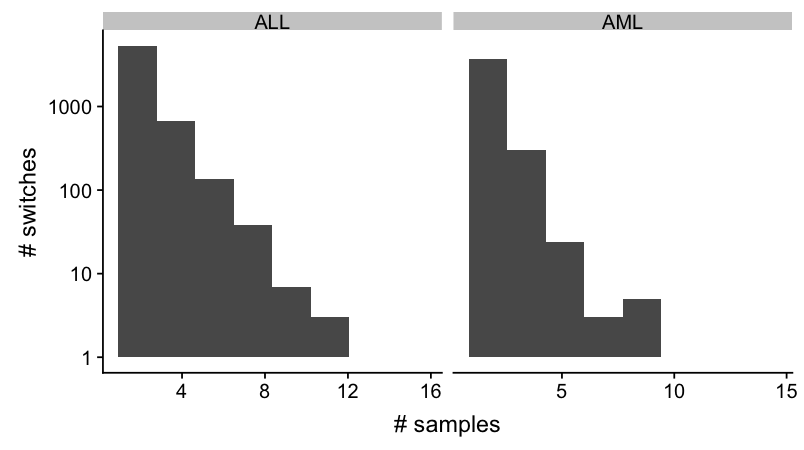

In [4]:
options(repr.plot.width=6.7, repr.plot.height=3.75)
ggplot(switches, aes(num_samples)) +
    geom_histogram(bins = 8) +
    facet_grid(. ~ Experiment, scales = 'free_x') +
    scale_y_log10() +
    labs(x = '# samples', y = '# switches')

# Significantly recurrent switches

In [5]:
all_switches <- strsplit(switches$Samples, ',') %>% unlist %>% length
all_samples <- strsplit(switches$Samples, ',') %>% unlist %>% unique %>% length
all_genes <- switches$GeneId %>% unique %>% length

switches$p_recurrent <- lapply(switches$num_samples, function(x) {
                binom.test(x, all_samples, all_switches/(all_samples * all_genes), 'greater')$p.value
              }) %>% unlist

cat('Surviving ALL switches = ', 
    sum(switches$Experiment == 'ALL' & switches$p_recurrent < 0.05))
cat('\nSurviving AML switches = ', 
    sum(switches$Experiment == 'AML' & switches$p_recurrent < 0.05))

Surviving ALL switches =  97
Surviving AML switches =  17

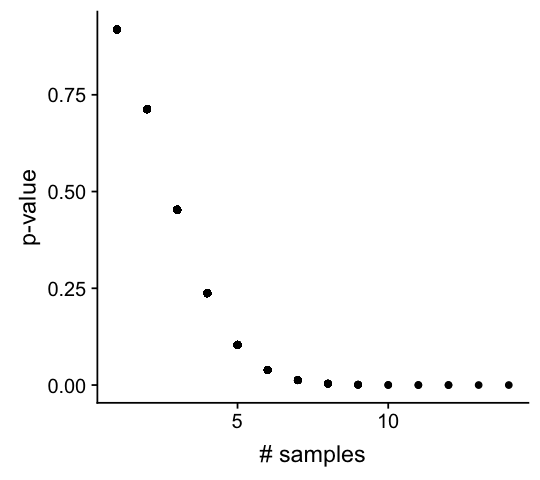

In [6]:
options(repr.plot.width=4.5, repr.plot.height=4)
ggplot(switches, aes(x = num_samples, y = p_recurrent)) +
    geom_point() +
    labs(x = '# samples', y = 'p-value')

In [7]:
sum(switches$p_recurrent < 0.05)

[1] 114

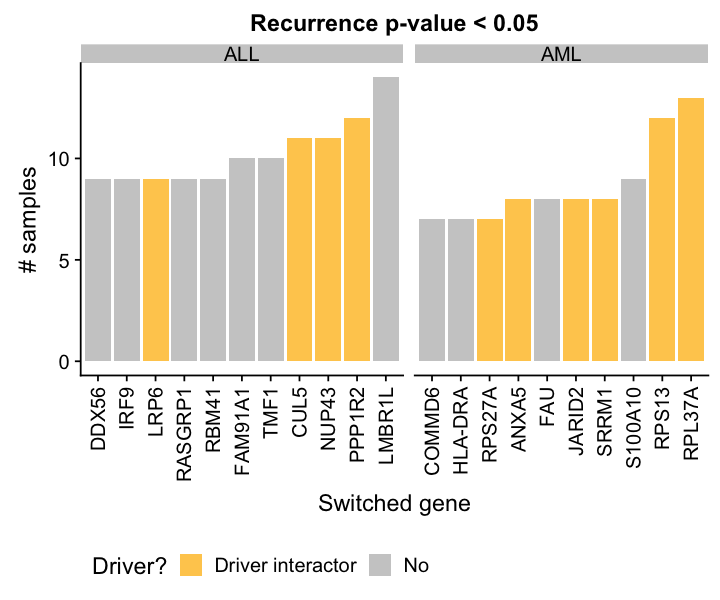

In [8]:
options(repr.plot.width=6, repr.plot.height=5)
filter(switches, p_recurrent < .05) %>%
    group_by(Experiment) %>%
    top_n(n = 10, wt = num_samples) %>%
    ggplot(aes(x = fct_reorder(Symbol, num_samples), y = num_samples, fill = Driver)) +
        geom_bar(stat = 'identity') +
        facet_grid(. ~ Experiment, scales = 'free_x', space = "free_x") +
        labs(x = 'Switched gene', y = '# samples', fill = 'Driver?', title = 'Recurrence p-value < 0.05') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'bottom') +
        scale_fill_manual(values = palette_driver)

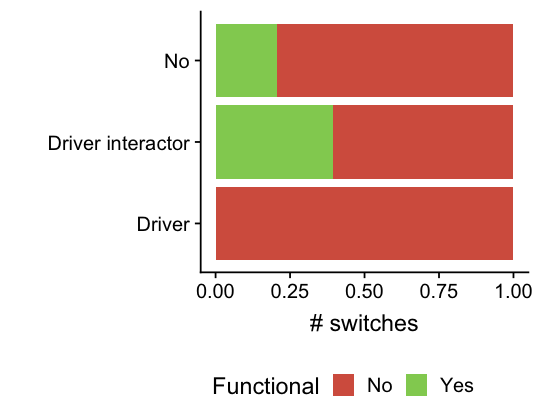

In [9]:
options(repr.plot.width=4.5, repr.plot.height=3.5)
filter(switches, p_recurrent < .05) %>%
    ggplot(aes(Driver, fill = Functional)) +
        geom_bar(position = 'fill') +
        coord_flip() +
        labs(x = '', y = '# switches', fill = 'Functional') +
        theme(legend.position = 'bottom') +
        scale_fill_manual(values = palette_yn)

# Use "noise" level

In [10]:
# Select main switches: 1 switch per gene, the one ocurring in more samples
main_switches <- group_by(switches, Experiment, GeneId) %>%
    summarize(Control_transcript = Control_transcript[which.max(num_samples)],
              Case_transcript = Case_transcript[which.max(num_samples)],
              num_samples = max(num_samples))

summary(main_switches$num_samples)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.638   2.000  14.000 

In [11]:
# Select noise switches: the switch opposite to the main switches
noise_switches <- full_join(switches, main_switches, by = c('Experiment', 'GeneId')) %>% 
    filter(Control_transcript.x == Case_transcript.y &
           Case_transcript.x == Control_transcript.y) %>%
    select(Experiment, GeneId, Control_transcript.x, Case_transcript.x, num_samples.x) %>%
    rename(Control_transcript = Control_transcript.x,
           Case_transcript = Case_transcript.x,
           num_samples = num_samples.x)

summary(noise_switches$num_samples)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.078   1.000   2.000 

In [12]:
min_all <- max(noise_switches$num_samples[noise_switches$Experiment == 'ALL'])
min_laml <- max(noise_switches$num_samples[noise_switches$Experiment == 'AML'])

main_switches <- filter(main_switches, (Experiment == 'ALL' & num_samples > min_all) |
                                       (Experiment == 'AML' & num_samples > min_laml))
switches <- inner_join(switches, main_switches, 
                       by = c("Experiment", "GeneId", "Control_transcript", 
                              "Case_transcript", "num_samples"))

for (t in tumors) {
    filter(switches, Experiment == t) %>%
    write_tsv(paste0(results, t, '/main_switches.tsv'))
}

cat('ALL threshold =', min_all, '. Surviving switches = ', 
    sum(main_switches$Experiment == 'ALL'))
cat('\nAML threshold =', min_laml, '. Surviving switches = ', 
    sum(main_switches$Experiment == 'AML'))

ALL threshold = 2 . Surviving switches =  839
AML threshold = 2 . Surviving switches =  337

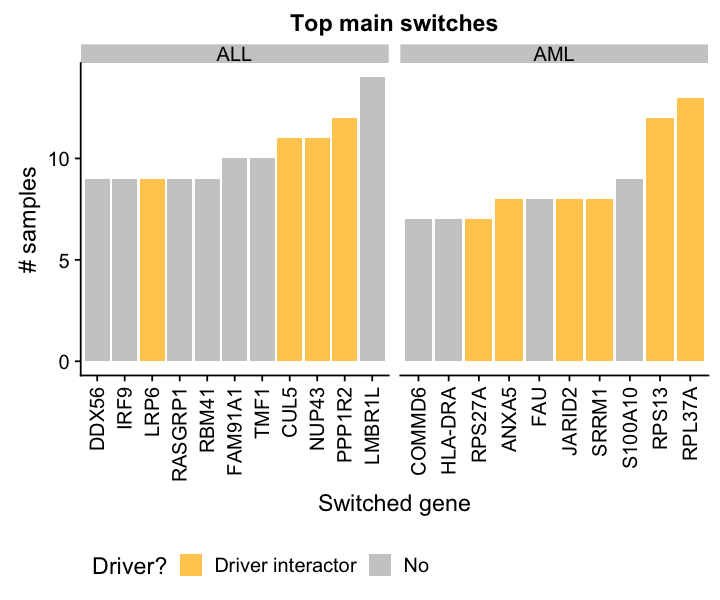

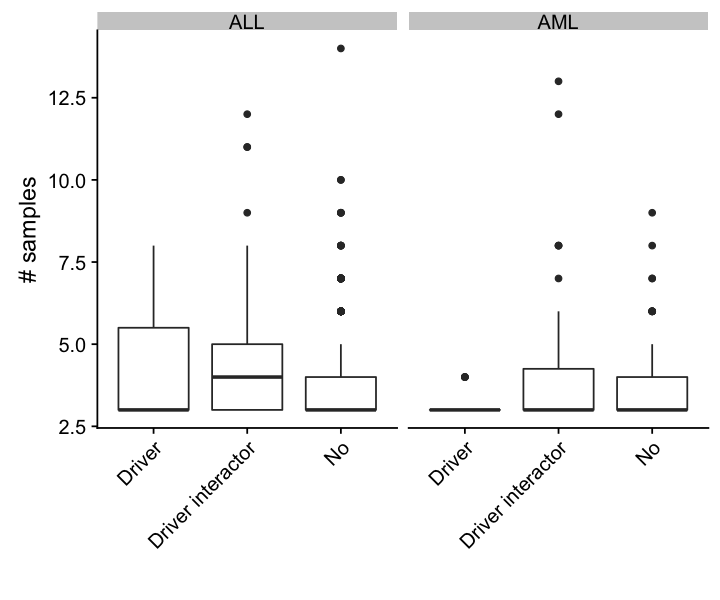

In [13]:
options(repr.plot.width=6, repr.plot.height=5)
switches %>%
    group_by(Experiment) %>%
    top_n(n = 10, wt = num_samples) %>%
    ggplot(aes(x = fct_reorder(Symbol, num_samples), y = num_samples, fill = Driver)) +
        geom_bar(stat = 'identity') +
        facet_wrap(. ~ Experiment, scales = 'free_x') +
        labs(x = 'Switched gene', y = '# samples', 
             fill = 'Driver?', title = 'Top main switches') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'bottom') +
        scale_fill_manual(values = palette_driver)

ggplot(switches, aes(x = Driver, y = num_samples)) +
    geom_boxplot() +
    facet_wrap(. ~ Experiment, scales = 'free_x') +
    labs(x = '', y = '# samples') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

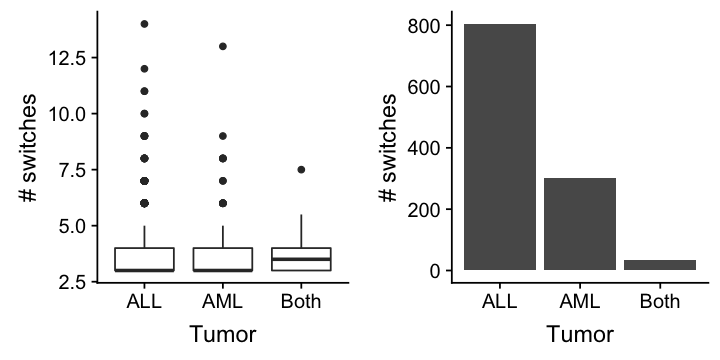

In [14]:
options(repr.plot.width=6, repr.plot.height=3)
hst_coocurrence <- switches %>%
    group_by(GeneId, Control_transcript, Case_transcript) %>%
    summarize(Where = ifelse(n() == 2, 'Both', unique(Experiment))) %>%
    ggplot(aes(Where)) +
        geom_bar() +
        labs(x = 'Tumor', y = '# switches')

bpt_coocurrence <- switches %>%
    group_by(GeneId, Control_transcript, Case_transcript) %>%
    summarize(Where = ifelse(n() == 2, 'Both', unique(Experiment)),
              num_samples = mean(num_samples)) %>%
    ggplot(aes(x = Where, y = num_samples)) +
        geom_boxplot() +
        labs(x = 'Tumor', y = '# switches')

plot_grid(bpt_coocurrence, hst_coocurrence)

## Alterations in gene function

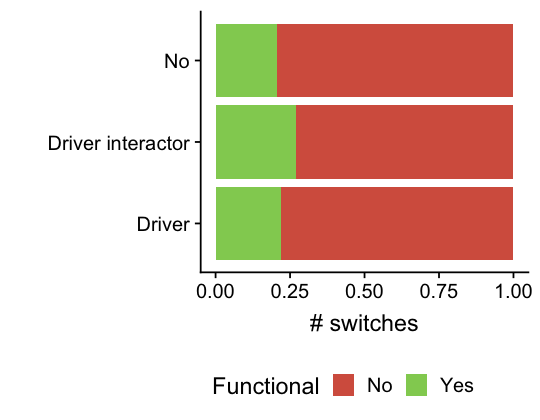

In [15]:
options(repr.plot.width=4.5, repr.plot.height=3.5)
ggplot(switches, aes(Driver, fill = Functional)) +
    geom_bar(position = 'fill') +
    coord_flip() +
    labs(x = '', y = '# switches', fill = 'Functional') +
    theme(legend.position = 'bottom') +
    scale_fill_manual(values = palette_yn)

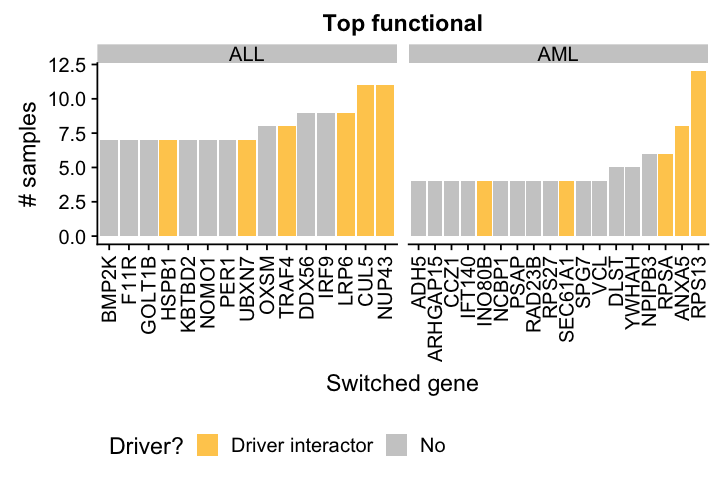

In [16]:
options(repr.plot.width=6, repr.plot.height=4)
switches %>%
    filter(Functional == 'Yes') %>%
    group_by(Experiment) %>%
    top_n(n = 10, wt = num_samples) %>%
    ggplot(aes(x = fct_reorder(Symbol, num_samples), y = num_samples, fill = Driver)) +
        geom_bar(stat = 'identity') +
        facet_wrap(. ~ Experiment, scales = 'free_x') +
        labs(x = 'Switched gene', y = '# samples', fill = 'Driver?', title = 'Top functional') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
              legend.position = 'bottom') +
        scale_fill_manual(values = palette_driver)